# Training Predictive Model

### Import libraries

In [1]:
import datetime, json, random, IPython, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torch, pytorch_lightning as pl
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger

from models import GazeDataModule, SingleModel, EyesModel, FullModel
from utils  import (
    get_config,
    tune_asha,
    get_best_results,
    save_model,
    plot_asha_param_grid,
    plot_parallel_param_loss,
    latest_tune_dir,
    _build_datamodule,
    _build_model,
    predict_screen_errors,
)

# project settings
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload
%autoreload 2


### Dataset information

In [2]:
df = pd.read_csv("data/positions.csv")
region_map = np.load("data/region_map.npy").T

print(f"# of samples: {len(df)}")
coverage = np.count_nonzero(region_map > 0) / region_map.size * 100
print(f"Coverage: {coverage:.2f}% of screen surface")
print(f"Crop size: {SETTINGS['image_size']} x {SETTINGS['image_size']} px")

# of samples: 56525
Coverage: 92.46% of screen surface
Crop size: 64 x 64 px


### Data visualization

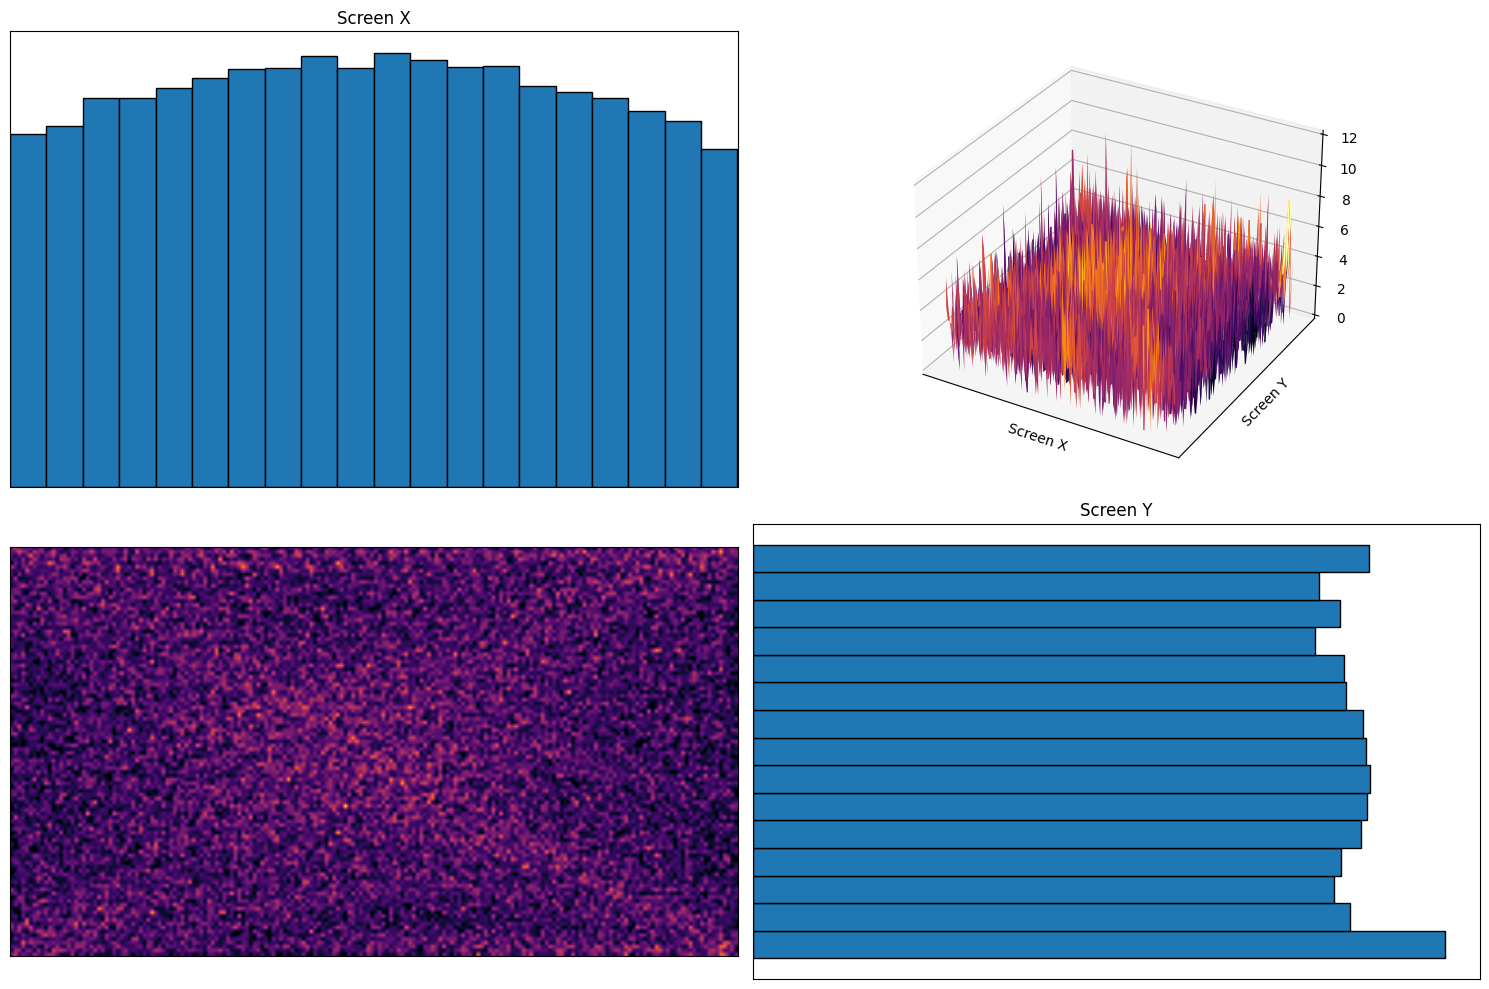

In [3]:
x = np.arange(region_map.shape[1])
y = np.arange(region_map.shape[0])
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
ax.hist(df['x'], bins=20, edgecolor='k')
ax.set_title('Screen X')
ax.margins(x=0)

ax = fig.add_subplot(222, projection='3d')
ax.dist = 9
ax.plot_surface(X, Y, region_map, cmap="inferno")
ax.set_xlabel('Screen X', labelpad=-10)
ax.set_ylabel('Screen Y', labelpad=-10)

ax = fig.add_subplot(223)
ax.imshow(region_map, interpolation='bilinear', cmap="inferno")

ax = fig.add_subplot(224)
ax.hist(df['y'], bins=15, edgecolor='k', orientation='horizontal')
ax.set_title('Screen Y')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.savefig('media/images/final_data_distribution.png')
plt.show()

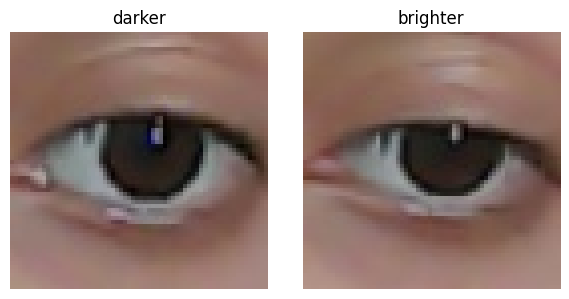

In [4]:
low_bright  = plt.imread("data/r_eye/12.jpg")
high_bright = plt.imread("data/r_eye/31.jpg")

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(low_bright);  axs[0].set_title("darker")
axs[1].imshow(high_bright); axs[1].set_title("brighter")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

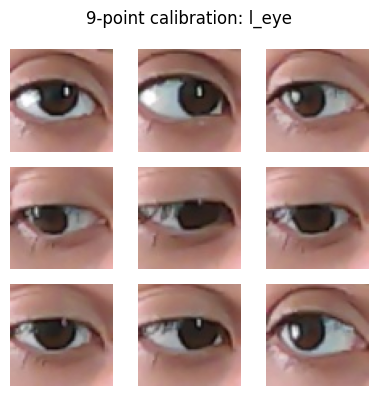

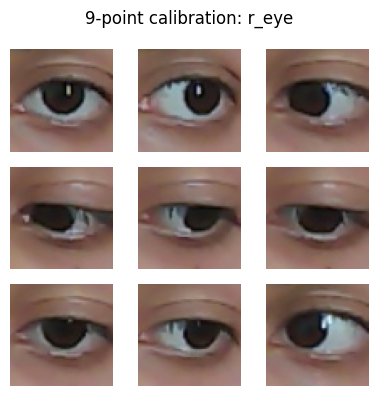

In [5]:
def plot_calibration(eye: str):
    idx = list(range(1, 10))
    imgs = [plt.imread(f"data/{eye}/{i}.jpg") for i in idx]

    fig, axs = plt.subplots(3, 3, figsize=(4, 4))
    order = [3, 6, 8, 2, 4, 7, 1, 0, 5]  # keep your original layout
    for ax, img_i in zip(axs.flat, order):
        ax.imshow(imgs[img_i])
        ax.axis("off")
    fig.suptitle(f"9-point calibration: {eye}")
    plt.tight_layout()
    plt.savefig(f"media/images/final_calibration_{eye}.png", dpi=120)
    plt.show()

plot_calibration("l_eye")
plot_calibration("r_eye")


### Fine tuning

In [ ]:
search_space = {
    "seed":  tune.randint(0, 10000),
    "bs":    tune.choice([256, 512, 1024, 2048]),
    "lr":    tune.loguniform(1e-4, 3e-3),
    "channels": tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "hidden":   tune.choice([128, 256, 512]),
}

analysis = tune_asha(
    search_space   = search_space,
    train_func     = "single",
    name           = "face/tune",
    img_types      = ["face"],
    num_samples    = 36,
    num_epochs     = 20,
    data_dir     = Path.cwd() / "data",
    seed           = 87,
)

2025-06-03 14:37:21,300	INFO worker.py:1852 -- Started a local Ray instance.
2025-06-03 14:37:24,812	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-06-03 14:37:24,815	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_tune_wrapper pid=14584) Seed set to 9444
(_tune_wrapper pid=14584) Using bfloat16 Automatic Mixed Precision (AMP)
(_tune_wrapper pid=14584) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(_tune_wrapper pid=14584) GPU available: True (cuda), used: True
(_tune_wrapper pid=14584) TPU available: False, using: 0 TPU cores
(_tune_wrapper pid=14584) HPU available: False, using: 0 HPUs
(_tune_wrapper pid=14584) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_tune_wrapper pid=14584) 
(_tune_wrapper pid=14584)   | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
(_tune_wrapper pid=14584) ------------------------------------------------------------------------------------------
(_tune_wrapper pid=14584) 0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
(_tune_wrapper pid=14584) 1 | mae       | MeanAbsoluteError | 0      | t

Trial name,checkpoint_dir_name,date,done,hostname,iterations_since_restore,loss,mae,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
_tune_wrapper_806a4_00000,checkpoint_000019,2025-06-03_15-30-10,True,DESKTOP-B40NR52,20,245.846,246.346,127.0.0.1,14584,True,3155.92,151.122,3155.92,1748957410,20,806a4_00000
_tune_wrapper_806a4_00001,checkpoint_000019,2025-06-03_16-13-17,True,DESKTOP-B40NR52,20,87.2789,87.7779,127.0.0.1,13076,True,2572.73,119.603,2572.73,1748959997,20,806a4_00001
_tune_wrapper_806a4_00002,checkpoint_000000,2025-06-03_16-23-43,True,DESKTOP-B40NR52,1,739.58,740.08,127.0.0.1,17636,True,613.302,613.302,613.302,1748960623,1,806a4_00002
_tune_wrapper_806a4_00003,checkpoint_000019,2025-06-03_17-14-56,True,DESKTOP-B40NR52,20,112.442,112.941,127.0.0.1,12680,True,3058.07,155.337,3058.07,1748963696,20,806a4_00003
_tune_wrapper_806a4_00004,checkpoint_000003,2025-06-03_17-26-24,True,DESKTOP-B40NR52,4,237.564,238.063,127.0.0.1,7228,True,670.711,139.684,670.711,1748964384,4,806a4_00004
_tune_wrapper_806a4_00005,checkpoint_000000,2025-06-03_17-30-08,True,DESKTOP-B40NR52,1,734.842,735.342,127.0.0.1,4780,True,210.987,210.987,210.987,1748964608,1,806a4_00005
_tune_wrapper_806a4_00006,checkpoint_000000,2025-06-03_17-33-32,True,DESKTOP-B40NR52,1,731.562,732.061,127.0.0.1,4740,True,188.041,188.041,188.041,1748964812,1,806a4_00006
_tune_wrapper_806a4_00007,checkpoint_000001,2025-06-03_17-37-34,True,DESKTOP-B40NR52,2,335.731,336.23,127.0.0.1,18932,True,230.981,61.7286,230.981,1748965054,2,806a4_00007
_tune_wrapper_806a4_00008,checkpoint_000000,2025-06-03_17-40-47,True,DESKTOP-B40NR52,1,738.702,739.201,127.0.0.1,9688,True,179.357,179.357,179.357,1748965247,1,806a4_00008
_tune_wrapper_806a4_00009,checkpoint_000015,2025-06-03_18-02-39,True,DESKTOP-B40NR52,16,128.453,128.952,127.0.0.1,18464,True,1300.06,73.6653,1300.06,1748966559,16,806a4_00009


(_tune_wrapper pid=14584) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250603-143717/806a4_00000/checkpoint_000000)
(_tune_wrapper pid=14584) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250603-143717/806a4_00000/checkpoint_000001)
(_tune_wrapper pid=14584) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250603-143717/806a4_00000/checkpoint_000002)
(_tune_wrapper pid=14584) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250603-143717/806a4_00000/checkpoint_000003)
(_tune_wrapper pid=14584) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/s

Best hyperparameters:  {'seed': 2851, 'bs': 256, 'lr': 0.0021106986216982027, 'channels': (48, 96, 192), 'hidden': 512}


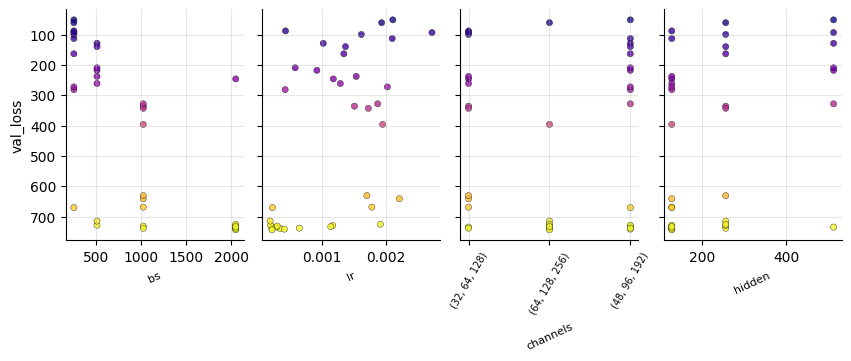

WindowsPath('media/images/final_face_explore_scatter.png')

In [7]:
plot_asha_param_grid(analysis, save_path="media/images/final_face_explore_scatter.png")

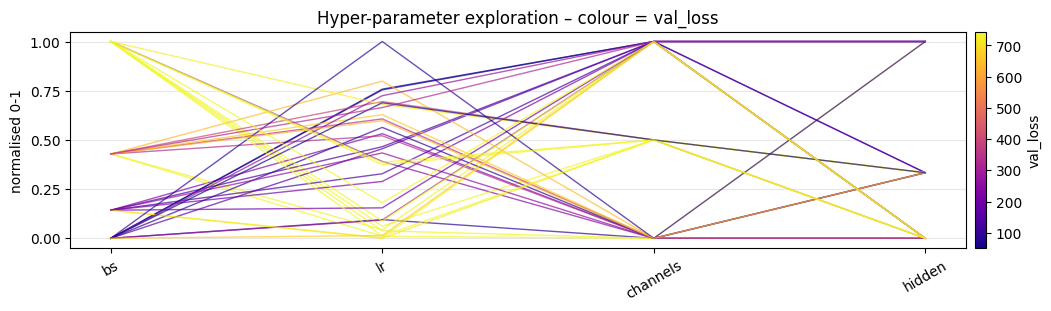

WindowsPath('media/images/final_face_explore_parallel.png')

In [8]:
plot_parallel_param_loss(analysis, save_path="media/images/final_face_explore_parallel.png")

### Training

In [9]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

tune_dir = Path.cwd() / "logs" / "face"
best_cfg = get_best_results(latest_tune_dir(tune_dir))
pl.seed_everything(best_cfg["seed"])

dm = GazeDataModule(
    data_dir = Path.cwd() / "data",
    batch_size = best_cfg["bs"],
    img_types = ["face"],
    seed = best_cfg["seed"],
)

model = _build_model(best_cfg, ["face"])

trainer = pl.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices = "auto",
    precision = "bf16-mixed",
    logger = TensorBoardLogger(
        save_dir = Path.cwd() / "logs",
        name     = f"face/final/{start_time}",
        log_graph = True,
    ),
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename = "best",
            monitor  = "val_loss",
            mode     = "min",
            save_last = True,
            save_top_k = 1,
        )
    ],
)

trainer.fit(model, datamodule=dm)
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)
model.load_state_dict(state["state_dict"])

out_dir = Path.cwd() / "logs" / "face" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

Seed set to 2851



--- Best of 'c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face\tune_20250603-143717' ---

Directory: 806a4_00010
Loss: 50.8
Pixel error: 7.13
Hyperparameters...
- seed: 2851
- bs: 256
- lr: 0.0021106986216982027
- channels: [48, 96, 192]
- hidden: 512


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------------------------
0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
3 | rmse      | MeanSquaredError  | 0      | train | ?              | ?             
4 | backbone  | ConvStack         | 209 K  | train | [1, 3, 64, 64] | [1, 192, 1, 1]
5 | regressor | Sequential        | 99.8 K | train | [1, 192, 1, 1] | [1, 2]        
------------------------------------------------------------------------------------------
309 K     Trainab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Model Evaluation

In [10]:
test_results = trainer.test(ckpt_path="best", datamodule=dm)[0]

loss = test_results["test_loss_epoch"]
mae  = test_results["test_mae_epoch"]

mse  = test_results.get("test_mse_epoch",  test_results.get("test_mse"))
rmse = test_results.get("test_rmse_epoch", test_results.get("test_rmse"))

print("────────  Test set  ────────")
print(f"MSE   : {mse:8.2f}  px²")
print(f"RMSE  : {rmse:8.2f}  px")
print(f"MAE   : {mae:8.2f}  px")
print(f"Loss  : {loss:8.2f}  (Smooth-L1)")

Restoring states from the checkpoint path at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face/final/2025-Jun-04 01-43-24\version_0\checkpoints\best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face/final/2025-Jun-04 01-43-24\version_0\checkpoints\best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     36.74839782714844     │
│      test_mae_epoch       │     37.24549865722656     │
│         test_mse          │     2506.494873046875     │
│         test_rmse         │     49.9510612487793      │
└───────────────────────────┴───────────────────────────┘

────────  Test set  ────────
MSE   :  2506.49  px²
RMSE  :    49.95  px
MAE   :    37.25  px
Loss  :    36.75  (Smooth-L1)


  0%|          | 0/56525 [00:00<?, ?it/s]

Average error: 50.52px over 5653 samples


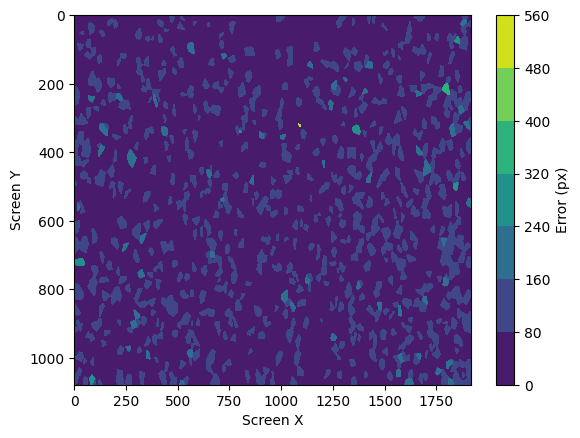

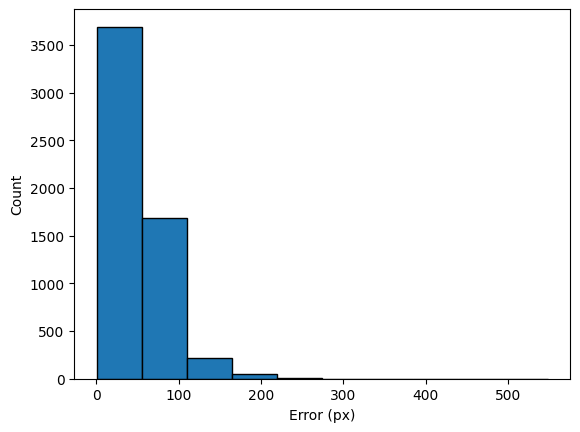

In [11]:
predict_screen_errors(
    "face",
    path_model  = out_dir/"eyetracking_model.pt",
    path_config = out_dir/"eyetracking_config.json",
    path_plot   = out_dir/"error_heatmap_face.png",
    path_errors = out_dir/"errors.npy",
    steps       = 10,
)